In [1]:
import pandas as pd
import numpy as np
import os


In [2]:

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
      in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts 

In [3]:
clinical_lung = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Analysis/clinical_lung_na1.csv')
clinical_lung.drop(columns=['condition_id'], inplace=True)

# clinical_lung.drop(columns=['None',
# 'Not Reported',
# 'Not reported-Comorbidity',
# 'Not specified',
# 'Others',
# 'Not Reported.1',
# 'unknown',
# 'Not Reported.4',
# 'Not done',
# 'Not Reported.2',
# 'Not Reported.3',
# 'Unknown result'], inplace=True)

country_mapping = {
    'China': 1,        # High medical capacity, large infrastructure, advanced technology
    'India': 2,        # Large infrastructure, but strained capacity due to population
    'South Africa': 3, # Developed healthcare, but regional disparities
    'Romania': 4,      # Developing EU healthcare standards
    'Ukraine': 5,      # Moderate capacity but strained due to recent conflicts
    'Belarus': 6,      # Moderate capacity, state-funded healthcare
    'Kazakhstan': 7,   # Developing healthcare system
    'Azerbaijan': 8,   # Developing healthcare system
    'Georgia': 9,      # Smaller healthcare capacity, improving
    'Moldova': 10,     # Limited resources, developing healthcare
    'Kyrgyzstan': 11,  # Limited resources, developing healthcare
    'Nigeria': 12,     # Limited healthcare capacity, large population challenges
    'Senegal': 13      # Developing healthcare system with limited resources
}

# Apply the mapping to the 'country' column
clinical_lung['country'] = clinical_lung['country'].replace(country_mapping)#.fillna(0)

clinical_lung['education'] = clinical_lung['education'] - 1
clinical_lung['education'] = clinical_lung['education'].replace({-1: np.nan})

clinical_lung = clinical_lung[clinical_lung['outcome']!= 'Completed']
clinical_lung = clinical_lung.drop_duplicates()

clinical_lung['outcome'].replace({'Cured': 1, 'Completed':0,'Died': 0, 'Failure': 0, 'Palliative Care': 0}, inplace=True)
# clinical_lung['outcome'].replace({'Cured': 3, 'Completed':0,'Died': 0, 'Failure': 1, 'Palliative Care': 2}, inplace=True)
clinical_lung_features = clinical_lung.drop(columns=['outcome', 'period_span.1'])
clinical_lung_target = clinical_lung[['outcome']]

/tmp/ipykernel_38363/722177739.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinical_lung['country'] = clinical_lung['country'].replace(country_mapping)#.fillna(0)
/tmp/ipykernel_38363/722177739.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clinical_lung['outcome'].replace({'Cured': 1

In [4]:
clinical_lung['Patient alcohol abuse'].value_counts()

Patient alcohol abuse
0    6596
1    1498
Name: count, dtype: int64

In [5]:
for x in clinical_lung.columns:
    print(x,':', clinical_lung[x].unique())
    

overall_percent_of_abnormal_volume : [1. 2. 0.]
pleural_effusion_percent_of_hemithorax_involved : [ 1. nan  0.  2.]
ispleuraleffusionbilateral : [ 0. nan  1.]
other_non_tb_abnormalities : [ 0. nan  1.]
are_mediastinal_lymphnodes_present : [ 1.  0. nan]
collapse : [0. 2. 1. 4. 3.]
smallcavities : [0. 2. 1. 4. 3. 5. 6.]
mediumcavities : [0. 3. 2. 1. 4. 6. 5.]
largecavities : [0. 1. 2. 3. 5. 4.]
isanylargecavitybelongtoamultisextantcavity : [0. 1. 3. 2. 4. 5.]
canmultiplecavitiesbeseen : [0. 1. 3. 2. 4. 5. 6.]
infiltrate_lowgroundglassdensity : [0. 3. 1. 6. 2. 5. 4.]
infiltrate_mediumdensity : [0. 1. 2. 3. 4. 6. 5.]
infiltrate_highdensity : [0. 1. 3. 6. 2. 5. 4.]
smallnodules : [4. 0. 3. 6. 1. 2. 5.]
mediumnodules : [2. 1. 3. 5. 0. 4. 6.]
largenodules : [0. 2. 1. 3. 4. 5.]
hugenodules : [0. 1. 2. 3.]
isanycalcifiedorpartiallycalcifiednoduleexist : [0. 1. 4. 3. 2. 5. 6.]
isanynoncalcifiednoduleexist : [5. 0. 3. 1. 4. 2. 6.]
isanyclusterednoduleexists : [0. 1. 2. 4. 3. 5. 6.]
aremultiplenod

### train xgb model with tbpt

In [6]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance



def evaluate_xgboost_classifier_split_weighted(
    X_train,
    X_test,
    y_train,
    y_test,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    gamma=0,
    min_child_weight=1,
    subsample=1.0,
    colsample_bytree=1.0,
    colsample_bylevel=1.0,
    colsample_bynode=1.0,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=None,
    booster='gbtree',
    objective='binary:logistic',
    eval_metric='mlogloss',
    random_state=42
):
    """
    Trains and evaluates an XGBoost classifier on the provided training and testing datasets with customizable parameters.

    Returns:
    - model (XGBClassifier): The trained XGBoost model.
    - metrics (dict): A dictionary containing accuracy, sensitivity, specificity, AUC-ROC, and F1-score.
    """

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to DataFrames to retain feature names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=np.array(y_train['outcome']))
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Calculate scale_pos_weight for binary classification
    if len(np.unique(y_train)) == 2:
        pos_class_weight = class_weights[1] / class_weights[0]
    else:
        pos_class_weight = None  # Adjust for multiclass if needed

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(
        use_label_encoder=False,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        colsample_bynode=colsample_bynode,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=scale_pos_weight,
        booster=booster,
        objective=objective,
        eval_metric=eval_metric,
        random_state=random_state
    )
    model.fit(X_train_scaled_df, y_train)

    # Predict on testing data
    y_test_pred = model.predict(X_test_scaled_df)
    y_test_pred_prob = model.predict_proba(X_test_scaled_df)[:, 1]  # Probability estimates for AUC-ROC

    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1, average='binary')
    specificity = recall_score(y_test, y_test_pred, pos_label=0, average='binary')
    auc_roc = roc_auc_score(y_test, y_test_pred_prob)
    f1 = f1_score(y_test, y_test_pred)

    # Compile metrics into a dictionary
    metrics = {
        'Testing Accuracy': test_accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity,
        'AUC-ROC': auc_roc,
        'F1-Score': f1
    }

    # Print metrics
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(25, 55))
    plot_importance(model, max_num_features=20, importance_type='weight', xlabel='Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

    return model, metrics

/mnt/storageG1/lwang/miniconda3/envs/tbpt/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


/mnt/storageG1/lwang/miniconda3/envs/tbpt/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/mnt/storageG1/lwang/miniconda3/envs/tbpt/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/mnt/storageG1/lwang/miniconda3/envs/tbpt/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:12:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Testing Accuracy: 0.9117
Sensitivity (Recall): 0.9262
Specificity: 0.8672
AUC-ROC: 0.9565
F1-Score: 0.9405


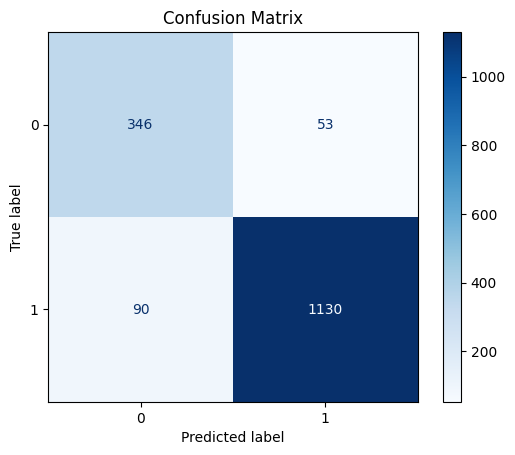

<Figure size 2500x5500 with 0 Axes>

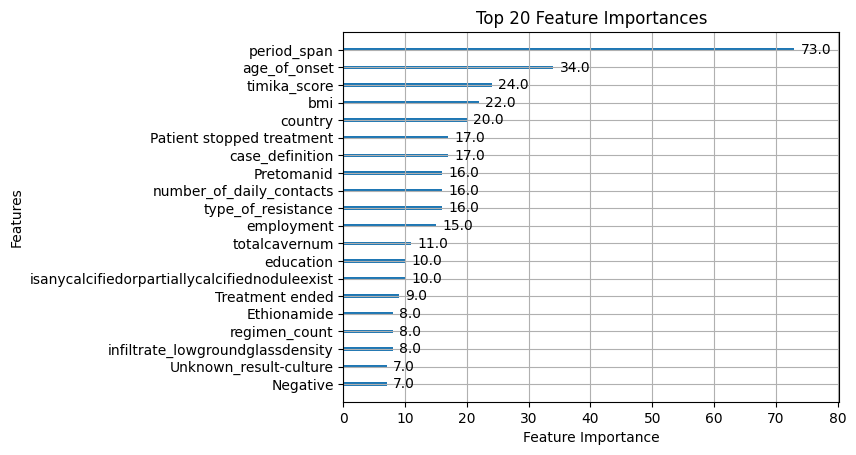

         Feature  Importance
35   period_span        73.0
34  age_of_onset        34.0
24  timika_score        24.0
30           bmi        22.0
23       country        20.0
..           ...         ...
71      Amikacin         1.0
90       1 to 19         1.0
88    Terizidone         1.0
92     20 to 100         1.0
96      Positive         1.0

[100 rows x 2 columns]


In [7]:
# imputer = SimpleImputer(strategy='most_frequent')

# # Fit the imputer on the data and transform it
# clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)
clinical_lung_features_imputed = clinical_lung_features

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features_imputed_df

import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# target_counts = {
#     1.0: 6311,  # Keep the majority class as is
#     0.0: 3311,  # Bring other classes closer
# }
# Initialize the RandomOverSampler
# ros = RandomOverSampler(random_state=42, sampling_strategy=target_counts)
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=0.3, reg_lambda=19,  random_state=42)
# evaluate_xgboost_classifier_split_weighted(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)
# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)
# model, metrics = evaluate_xgboost_classifier_split_weighted(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)

# for data with none columns
model, metrics = evaluate_xgboost_classifier_split_weighted(
    X_train_resampled, X_test, y_train_resampled, y_test,
    max_depth=12,
    learning_rate=0.5,
    n_estimators=300,
    gamma=0.5,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_alpha=38, reg_lambda=69,
    random_state=42,
)

# model, metrics = evaluate_xgboost_classifier_split_weighted(
#     X_train_resampled, X_test, y_train_resampled, y_test,
#     max_depth=8,
#     learning_rate=0.9,
#     n_estimators=400,
#     gamma=0.5,
#     min_child_weight=2,
#     subsample=0.8,
#     colsample_bytree=0.9,
#     reg_alpha=38, reg_lambda=69,
#     random_state=42,
# )

# Extract feature importance from the trained model
feature_importances = model.get_booster().get_score(importance_type='weight')

# Convert to a DataFrame for better readability
importance_df = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
}).sort_values(by='Importance', ascending=False)

# Display or save the DataFrame
print(importance_df)

### preparing external philippines model

In [ ]:
# for x in external_data.columns:
#     print(x,':', external_data[x].unique())


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def map_employment(occupation):
    occupation = str(occupation).strip().upper() if pd.notnull(occupation) else None

    if occupation in ['NONE', 'UNEMPLOYED', 'NO DATA', 'HOUSEWIFE - NONE', 'HOUSEWIFE/NONE', 'UNEMPLOYED / NONE', 'OUT OF SCHOOL YOUTH', 'JOBLESS']:
        return 0  # Unemployed
    elif occupation in ['SELF-EMPLOYED', 'ENTREPRENEUR', 'BUY AND SELL', 'BUSINESSWOMAN', 'BUSINESSMAN', 'SELLING FISH IN THE MARKET', 'STORE OWNER', 'VENDOR', 'MARKET VENDOR', 'VEGETABLE VENDOR', 'BALOT VENDOR', 'FISH VENDOR', 'SIDEWALK VENDOR', 'SARI-SARI STORE OWNER', 'SARI-SARI STORE VENDOR']:
        return 1  # Self-employed
    elif occupation in ['TRICYCLE DRIVER', 'DRIVER', 'TRICYCLE DRIVER, BARANGAY TANOD', 'MOTORCYCLE DRIVER', 'TAXI DRIVER', 'PUJ DRIVER', 'JEEPNEY DRIVER', 'MOTORELA DRIVER', 'PEDICAB DRIVER', 'SIDECAR DRIVER', 'POTPOT DRIVER', 'DRIVER TRUCK', 'SERVICE DRIVER', 'DELIVERY BOY', 'DELIVERY TRUCK DRIVER', 'DRUMMER']:
        return 2  # Unofficially employed
    elif occupation in ['FARMER', 'LABORER', 'HOUSEKEEPER', 'CARPENTER', 'MECHANIC', 'FISHERMAN', 'JANITOR', 'FACTORY WORKER', 'UTILITY WORKER', 'SECURITY GUARD', 'TEACHER', 'GOVERNMENT EMPLOYEE', 'BUS DRIVER', 'BRGY. KAGAWAD', 'POLICEMAN', 'POLICE OFFICER', 'NURSE', 'EMPLOYEE', 'CONSTRUCTION WORKER', 'ELECTRICIAN', 'BRGY. HEALTH WORKER', 'CLERK', 'FOREMAN', 'HOUSEBOY', 'COOK', 'ASSISTANT COOK', 'WAITER', 'FOOD SERVER', 'DISHWASHER', 'CASHIER', 'BARBER', 'SEWER', 'SARI-SARI STORE OWNER', 'INSPECTOR', 'GARBAGE COLLECTOR', 'MASON', 'SALESMAN', 'SALESLADY', 'SALES CLERK', 'SALESLADY OF RTW', 'ACCOUNTING CLERK', 'ADMIN ASSISTANT']:
        return 3  # Employed
    elif occupation in ['RETIRED', 'RETIRED EMPLOYEE', 'RETIRED POLICE', 'RETIRED COOK', 'RETIRED GOVERNMENT EMPLOYEE', 'RETIRED MILITARY']:
        return 4  # Retired
    elif occupation in ['HOUSEWIFE', 'HOMEMAKER']:
        return 5  # Homemaker
    elif occupation in ['STUDENT', 'COLLEGE STUDENT', 'HIGH SCHOOL STUDENT', 'ELEMENTARY TEACHER', 'ARABIC STUDENT', 'HIGH STUDENT']:
        return 6  # Student
    elif occupation in ['DISABLED', 'INMATE', 'PRISONER']:
        return 7  # Disabled
    else:
        return np.nan  # Not reported / can't classify

def classify_resistance(inh, rif, eth, strept, oflox, levo, kana, amika, capreo):
    try:
        resistant_drugs = sum([
            inh == 'Resistant', rif == 'Resistant', eth == 'Resistant', strept == 'Resistant',
            oflox == 'Resistant', levo == 'Resistant', kana == 'Resistant', amika == 'Resistant', capreo == 'Resistant'
        ])
        if (inh == 'Resistant' and rif == 'Resistant'):
            if resistant_drugs >= 4:
                return 6 # XDR
            else:
                return 4 #'MDR'
        else:
            return 0
    except:
        return np.nan

def map_outcome(outcome_code):
    if outcome_code == 1:
        return 1  # Cured, success
    elif outcome_code in [2, 3]:
        return 0  # Failure, Died
    else:
        return np.nan

def prepare_external_dataset(raw_df, model_expected_columns):
    df = raw_df.copy()

    processed = pd.DataFrame()
    processed['employment'] = df['occupation'].apply(map_employment)

    # 1. Demographics
    processed['age_of_onset'] = df['age']
    processed['bmi'] = df['weight'] / (df['height']**2)
    processed['gender'] = df['sex'].map({1: 0, 2: 1})

    # 2. Comorbidities
    processed['HIV'] = df['hivresult'].map({1: 1, 0: 0}).fillna(np.nan)
    processed['Diabetes'] = df['diabetes'].map({1: 1, 0: 0}).fillna(np.nan)

    # 3. Smoking and Alcohol
    processed['Current smoker'] = df['smoke'].map({1: 1, 0: 0}).fillna(np.nan)
    processed['Patient alcohol abuse'] = df['drinkoften'].map({1: 1, 2: 0, 3: 0}).fillna(np.nan)

    # 4. Type of resistance
    processed['type_of_resistance'] = df.apply(
        lambda row: classify_resistance(
            inh=row.get('isoniazid'), rif=row.get('rifampicin'),
            eth=row.get('ethambutol'), strept=row.get('streptomycin'),
            oflox=row.get('ofloxacin'), levo=row.get('levofloxacin'),
            kana=row.get('kanamycin'), amika=row.get('amikacin'), capreo=row.get('capreomycin')
        ),
        axis=1
    )

    # 5. Culture result
    processed['culture'] = df['culture'].map({
        'Positive': 'Positive', 'Negative': 'Negative',
        'MTB': 'Positive', 'NO GROWTH': 'Negative'
    }).fillna('Unknown')

    # 6. Lung-related imaging features (not available)
    lung_features = [
        'overall_percent_of_abnormal_volume', 'pleural_effusion_percent_of_hemithorax_involved',
        'ispleuraleffusionbilateral', 'other_non_tb_abnormalities', 'are_mediastinal_lymphnodes_present',
        'collapse', 'smallcavities', 'mediumcavities', 'largecavities',
        'isanylargecavitybelongtoamultisextantcavity', 'canmultiplecavitiesbeseen',
        'infiltrate_lowgroundglassdensity', 'infiltrate_mediumdensity', 'infiltrate_highdensity',
        'smallnodules', 'mediumnodules', 'largenodules', 'hugenodules',
        'isanycalcifiedorpartiallycalcifiednoduleexist', 'isanynoncalcifiednoduleexist',
        'isanyclusterednoduleexists', 'aremultiplenoduleexists',
        'lowgroundglassdensityactivefreshnodules', 'mediumdensitystabalizedfibroticnodules',
        'highdensitycalcifiedtypicallysequella', 'timika_score'
    ]
    for col in lung_features:
        processed[col] = np.nan

    # 7. Socioeconomic risk factors
    processed['employment'] = df['Occupation_recode'].fillna(np.nan)
    processed['education'] = np.nan  # no education field available

    # 8. Treatment features
    processed['period_span'] = np.nan
    processed['regimen_count'] = np.nan

    # 9. Bacteriology data (GeneXpert, Bactec)
    processed['genexpert_test'] = np.nan
    processed['bactec_isoniazid'] = df['inhd7'].map({1: 1, 0: 0}).fillna(np.nan)
    processed['bactec_rifampicin'] = df['rifamd7'].map({1: 1, 0: 0}).fillna(np.nan)
    processed['bactec_ethambutol'] = df['ethamd7'].map({1: 1, 0: 0}).fillna(np.nan)
    # processed['outcome'] = df['outcome_d12'].map({1: 1, 0: 0}).fillna(np.nan)

    # 10. Clinical outcome mapping
    processed['outcome'] = df['outcome_d12'].apply(map_outcome)

    # 11. Remaining comorbidities and social risks (optional)
    comorbids_social = [
        'Anemia', 'Psychiatric illness', 'Renal disease', 'COVID-19',
        'Homeless', 'Ex prisoner', 'Immigrants', 'TB care worker',
        'Patient alcohol abuse not available/unknown', 'Patient drug abuse',
        'Patient smoking data not available/unknown', 'Worked abroad',
        'internal migrants', 'refugees'
    ]
    for col in comorbids_social:
        processed[col] = np.nan

    # 12. Diagnosis codes
    for code in [
        'A15.0', 'A15.1', 'A15.2', 'A15.3', 'A15.4', 'A15.5', 'A15.6', 'A15.7',
        'A15.8', 'A15.9', 'A16', 'A16.0', 'A16.2', 'A16.3', 'A16.5', 'A16.8',
        'A17.0', 'A18.0', 'A18.1', 'A18.2', 'A18.3', 'A18.4', 'A18.7', 'A18.8',
        'A19.0', 'A19.1', 'A19.8', 'A19.9'
    ]:
        processed[code] = np.nan
    label = processed['outcome'].copy()
    # 13. Align to model expected columns
    for col in model_expected_columns:
        if col not in processed.columns:
            processed[col] = np.nan

    processed = processed[model_expected_columns]

    return processed, label

# Example usage
# external_data = pd.read_csv('external_dataset.csv')
# model_expected_columns = list(model.feature_names_in_)
# processed_external_data = prepare_external_dataset(external_data, model_expected_columns)
# preds = model.predict_proba(processed_external_data)[:, 1]
# print(preds)

In [9]:
clinical_lung_features['gender']

1        0
2        0
3        1
4        0
5        0
        ..
10143    0
10145    0
10147    0
10148    0
10149    0
Name: gender, Length: 8094, dtype: int64

In [10]:
external_data['sex']

NameError: name 'external_data' is not defined

In [11]:
# Example code to run the preparation and prediction
external_data = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Analysis/PHILDRS2_02132017_processed.csv')
external_data = external_data.replace(9, np.nan)
model_expected_columns = list(clinical_lung_features.columns)  # assuming you saved them
processed_external_data, processed_outcome = prepare_external_dataset(external_data, model_expected_columns)

/tmp/ipykernel_3590/1752753779.py:145: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed[col] = np.nan
/tmp/ipykernel_3590/1752753779.py:145: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed[col] = np.nan
/tmp/ipykernel_3590/1752753779.py:145: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [12]:
processed_data = pd.concat([processed_external_data, processed_outcome], axis=0)
processed_data = processed_data.dropna(how='all', subset=[col for col in processed_data.columns if col != 'outcome'])
processed_data_input = processed_data.drop(columns=['outcome'])

# processed_data_ = processed_data[processed_data['outcome'].notna()]
# processed_data_input = processed_data_.drop(columns=['outcome'])
# processed_data_target = processed_data_[['outcome']]

In [15]:
processed_external_data

,overall_percent_of_abnormal_volume,pleural_effusion_percent_of_hemithorax_involved,ispleuraleffusionbilateral,other_non_tb_abnormalities,are_mediastinal_lymphnodes_present,collapse,smallcavities,mediumcavities,largecavities,isanylargecavitybelongtoamultisextantcavity,...,Unknown_result-culture,La1,La2,lineage1,lineage1-lineage2,lineage2,lineage2-lineage4,lineage3,lineage3-lineage4,lineage4
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### test xgb model with philippines data

#### all missing col set to na

In [ ]:
output = model.predict(processed_data_input)
value_counts_list(output)

#### all missing col omited in retraining

In [19]:
processed_data_input_dropna = processed_data_input.dropna(axis=1, how='all')

In [20]:
processed_data_input_dropna.columns

Index(['gender', 'employment', 'type_of_resistance', 'bmi', 'age_of_onset',
       'bactec_isoniazid', 'bactec_rifampicin', 'bactec_ethambutol',
       'Diabetes', 'HIV', 'Current smoker', 'Patient alcohol abuse'],
      dtype='object')

In [22]:
clinical_lung_features[processed_data_input_dropna.columns]

,gender,employment,type_of_resistance,bmi,age_of_onset,bactec_isoniazid,bactec_rifampicin,bactec_ethambutol,Diabetes,HIV,Current smoker,Patient alcohol abuse
1,0,0.0,1,NaN,40,0.0,0.0,0.0,0,0,0,0
2,0,3.0,1,NaN,29,NaN,NaN,NaN,0,0,0,0
3,1,0.0,1,NaN,23,NaN,NaN,NaN,0,0,0,0
4,0,0.0,1,NaN,60,NaN,NaN,NaN,0,0,0,0
5,0,3.0,1,24.2,48,NaN,NaN,NaN,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10143,0,0.0,1,NaN,23,NaN,NaN,NaN,0,0,0,0
10145,0,0.0,6,23.6,48,3.0,3.0,3.0,0,0,1,0
10147,0,0.0,4,23.8,37,3.0,3.0,3.0,0,0,1,0
10148,0,0.0,4,16.7,44,3.0,3.0,3.0,0,0,1,0


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:39:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Testing Accuracy: 0.7251
Sensitivity (Recall): 0.7172
Specificity: 0.7494
AUC-ROC: 0.7925
F1-Score: 0.7973


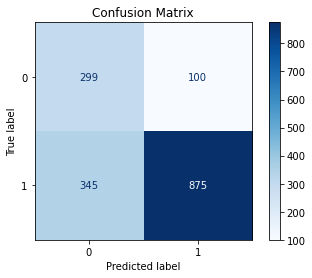

<Figure size 1800x3960 with 0 Axes>

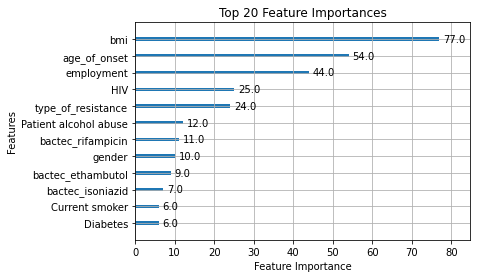

In [23]:
# imputer = SimpleImputer(strategy='most_frequent')

# # Fit the imputer on the data and transform it
# clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)
clinical_lung_features_imputed = clinical_lung_features

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features[processed_data_input_dropna.columns]

import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# target_counts = {
#     1.0: 6311,  # Keep the majority class as is
#     0.0: 3311,  # Bring other classes closer
# }
# Initialize the RandomOverSampler
# ros = RandomOverSampler(random_state=42, sampling_strategy=target_counts)
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=0.3, reg_lambda=19,  random_state=42)
# evaluate_xgboost_classifier_split_weighted(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)
# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)
# model, metrics = evaluate_xgboost_classifier_split_weighted(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)

# for data with none columns
model, metrics = evaluate_xgboost_classifier_split_weighted(
    X_train_resampled, X_test, y_train_resampled, y_test,
    max_depth=12,
    learning_rate=0.5,
    n_estimators=300,
    gamma=0.5,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_alpha=38, reg_lambda=69,
    random_state=42,
)


In [24]:
output = model.predict(processed_data_input)
value_counts_list(output)

{0: 3570, 1: 1}

## TBWEB

In [8]:
df_tbweb = pd.read_excel('../TBWEB/tuberculosis-data-06-16-full-eng.xlsx')

df_tbweb['cultEsc'] = df_tbweb[['cultEsc', 'CULTOTHER']].apply(
    lambda x: 'Pos' if 'Pos' in x.values else ('Neg' if 'Neg' in x.values else np.nan), axis=1
)
df_tbweb['bac'] = df_tbweb[['bac','BACOOUTRO']].apply(
    lambda x: 'Positive' if 'Positive' in x.values else ('Negative' if 'Negative' in x.values else np.nan), axis=1
)

df_tbweb.drop(columns=['Unnamed: 0', 'FORMACLIN2','FORMACLIN3', 'COMMUNICAXA','COMMUNICATION','CULTOTHER','BACOOUTRO','RXOUTRO','NECROP'
                       ], inplace=True)

descriptions = ["Patient self-referred ethnicity","Age group","Gender","Pregnancy","Scholarity","Type of occupation","Previous treatment code","Time-lapse from previous treatment (in years)","Current state","Type of case","Clinical form","Classification","Case-finding method","Smear microscopy","Sputum culture","Chest X-Ray","HIV","Sensibility test","AIDS","Diabetes","Alcoholism","Mental disease","Drug addiction","Smoking","Number of people that live with the patient","Institution type","Initial treatment scheme","Treatment scheme change","Current scheme","Scheme change reason","Treatment type","Number of doses up to the 2nd month","Number of doses from 3rd to 6th month","Age","Histopathological","Other immunosuppression","Resistance","Reason for hospitalization"]
df_tbweb.columns = descriptions

df_tbweb.drop(columns=['Age group'], inplace=True)
threshold = len(df_tbweb) * 0.5
df_tbweb = df_tbweb.dropna(axis=1, thresh=threshold)

In [9]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Replace these with your actual column names
clinical_lung_features_imputed_columns = clinical_lung_features_imputed.columns
df_tbweb_columns = df_tbweb.columns

# Load a transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embed the feature names
clinical_embeddings = model.encode(clinical_lung_features_imputed_columns, convert_to_tensor=True)
tbweb_embeddings = model.encode(df_tbweb_columns, convert_to_tensor=True)

# Compute cosine similarity
similarity_scores = util.pytorch_cos_sim(tbweb_embeddings, clinical_embeddings)

# Create a readable mapping
results = []
for i, tbweb_col in enumerate(df_tbweb_columns):
    for j, clinical_col in enumerate(clinical_lung_features_imputed_columns):
        similarity = similarity_scores[i][j].item()
        results.append((tbweb_col, clinical_col, similarity))

# Sort and show the most relevant mappings
similarity_df = pd.DataFrame(results, columns=["df_tbweb_column", "clinical_lung_feature", "similarity"])
similarity_df = similarity_df.sort_values(by="similarity", ascending=False)

/mnt/storageG1/lwang/miniconda3/envs/tbpt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/storageG1/lwang/miniconda3/envs/tbpt/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [10]:
top_matches = similarity_df.groupby("df_tbweb_column", as_index=False).first()
top_matches = top_matches.sort_values(by="similarity", ascending=False)


In [11]:
deduped = top_matches.drop_duplicates(subset=["clinical_lung_feature"], keep="first")
deduped_ = deduped[deduped['similarity']>0.5]

In [ ]:
deduped_['clinical_lung_feature']

,df_tbweb_column,clinical_lung_feature,similarity
10,Gender,gender,1.000000
11,HIV,HIV,1.000000
8,Diabetes,Diabetes,1.000000
14,Mental disease,Psychiatric illness,0.855335
26,Type of case,case_definition,0.773976
9,Drug addiction,Patient drug abuse,0.725691
2,Alcoholism,Patient alcohol abuse,0.682625
25,Treatment type,Continuation of treatment,0.627311
1,Age,age_of_onset,0.593197
27,Type of occupation,employment,0.558721


In [23]:
df_tbweb['Current state'] = df_tbweb['Current state'].replace({'Cure': 1, 'Abandonment': 0})

/tmp/ipykernel_38363/192409437.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tbweb['Current state'] = df_tbweb['Current state'].replace({'Cure': 1, 'Abandonment': 0})


In [27]:
df_tbweb_X = df_tbweb[deduped_['df_tbweb_column']]
df_tbweb_y = df_tbweb['Current state']

In [31]:
for x in clinical_lung_features[deduped_['clinical_lung_feature']].columns:
    print(x,':', clinical_lung_features[deduped_['clinical_lung_feature']][x].unique())

gender : [0 1]
HIV : [0 1]
Diabetes : [0 1]
Psychiatric illness : [0 1]
case_definition : [ 6.  4.  3.  5.  2.  1. nan]
Patient drug abuse : [0 1]
Patient alcohol abuse : [0 1]
Continuation of treatment : [0 1]
age_of_onset : [40 29 23 60 48 38 58 47 73 41 50 33 53 57 54 52 55 46 31 76 26 20 45 25
 28 85 49 44 37 39 30 36 61 75 63 15 35 51 43 62 56 77 24 42 66 32 59 34
 65 69 87 19 27 11 16 21 84 68 72 80 78 64 18 83 71 17 67 74 10 22  9 81
 70 79 82 93 13  6 14 86 88  5  4  1 12  3 91 90 89  7  2]
employment : [ 0.  3.  4.  7.  5. nan  6.  2.  1.]
Current smoker : [0 1]


In [29]:
for x in df_tbweb_X.columns:
    print(x,':', df_tbweb_X[x].unique())

Gender : ['M' 'F']
HIV : ['Pos' 'Neg' nan 'And']
Diabetes : ['N' 'S']
Mental disease : ['N' 'S']
Type of case : ['New' 'Retr Aband' 'Relapse' 'Portrait after bankruptcy/resistance'
 'Portrait after changing int/tox scheme']
Drug addiction : ['N' 'S']
Alcoholism : ['N' 'S']
Treatment type : ['Self-Administered' 'Supervised' nan]
Age : [ 26  38  24  35  41  25  23  30  65  40  27  19  48  52  36  47  51  66
  34  18  59  37  55  46  32  43  31  44   2  29  12  33  57  56  54  21
  42  45  16  17  20  39  22  60  49  58  50  63  80  70  75  28  67   0
  61  15  74  82  73  79  76   1   5   8  10  62  53   7   9  13  72  64
  14  71  91  81  69  88  68  77  11   6   3   4  86  92  87  84  78  83
  89  94  85 101  93  90  98 100  96  95]
Type of occupation : ['Other' 'Housewife' 'Health Professional' 'Unemployed' nan 'Retiree']
Smoking : ['N' 'S']


In [ ]:
# imputer = SimpleImputer(strategy='most_frequent')

# # Fit the imputer on the data and transform it
# clinical_lung_features_imputed = imputer.fit_transform(clinical_lung_features)
clinical_lung_features_imputed = clinical_lung_features

# Convert the result back to a DataFrame
clinical_lung_features_imputed_df = pd.DataFrame(clinical_lung_features_imputed, columns=clinical_lung_features.columns)

# Optionally, replace the original DataFrame with the imputed one
clinical_lung_features = clinical_lung_features[deduped_['clinical_lung_feature']]

import pandas as pd
from sklearn.utils import resample

# Assuming 'clinical_lung' is your DataFrame and 'outcome' is the target column
X_train, X_test, y_train, y_test = train_test_split(
    clinical_lung_features, clinical_lung_target, test_size=0.2, random_state=42, stratify=clinical_lung_target, shuffle=True
)

from imblearn.over_sampling import RandomOverSampler

# target_counts = {
#     1.0: 6311,  # Keep the majority class as is
#     0.0: 3311,  # Bring other classes closer
# }
# Initialize the RandomOverSampler
# ros = RandomOverSampler(random_state=42, sampling_strategy=target_counts)
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=0.3, reg_lambda=19,  random_state=42)
# evaluate_xgboost_classifier_split_weighted(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)
# evaluate_xgboost_classifier_split(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)
# model, metrics = evaluate_xgboost_classifier_split_weighted(X_train_resampled, X_test, y_train_resampled, y_test, reg_alpha=38, reg_lambda=69,  random_state=42)

# for data with none columns
model, metrics = evaluate_xgboost_classifier_split_weighted(
    X_train_resampled, X_test, y_train_resampled, y_test,
    max_depth=12,
    learning_rate=0.5,
    n_estimators=300,
    gamma=0.5,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_alpha=38, reg_lambda=69,
    random_state=42,
)
